<br><br>

<font color=#191347 ><font>
<p style = "font-family:times;">
    <font size="7">
        Interactive Learning 
    </font>    
</p>

<br>
    
<font color=#ed1c24><font>
<p style = "font-family:optima;">
    <font size="6">
        Homework #5
    </font>    
<font color=#000000> <font>
</p>

> $\textit{Mohammad Saadati - 810198410}$

# Table of Contents

- [Packages](#0)
- [Part 1](#1)
    - [States, Actions, Reward](#1-1)
    - [Continuous & Discrete](#1-2)
- [Part 2](#2)
    - [Deep Q-Learning](#2-1)
    - [Reward](#2-2)
    - [Render](#2-3)
    - [Hyperparameters](#2-4)
- [Part 3](#3)
    - [Result](#3-1)
- [Part 4](#4)
    - [Subsection 1](#4-1)
    - [Subsection 2](#4-2)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [ ]:
! pip install gym
! pip install highway-env
import gym
import highway_env

import time
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 33.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827651 sha256=5c28bbd1e8a8f1ebfd7776a55720404eeb2d9b1bdb9a2f1f838ad29c8bf54741
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [ ]:
# !pip install pygame 

# import os
# os.environ['SDL_VIDEODRIVER']='dummy'
# import pygame
# pygame.display.set_mode((640,480))

<a name='1'></a>
# Part 1

In [ ]:
env = gym.make("highway-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_size, action_size 

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


(5, 5)

<a name='1-1'></a>
## States, Actions, Reward

In [ ]:
env.reset()

(array([[ 1.        ,  0.91715866,  0.        ,  0.3125    ,  0.        ],
        [ 1.        ,  0.09712796,  0.        , -0.02975602,  0.        ],
        [ 1.        ,  0.19952334,  0.5       , -0.03954718,  0.        ],
        [ 1.        ,  0.31263483,  0.75      , -0.02641258,  0.        ],
        [ 1.        ,  0.4187949 ,  0.75      , -0.04170297,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 1,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 0.0,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [ ]:
action = env.action_type.actions_indexes["IDLE"]
obs, reward, done, truncated, info = env.step(action)

In [ ]:
obs 

array([[ 1.        ,  1.        ,  0.        ,  0.3125    ,  0.        ],
       [ 1.        ,  0.08364468,  0.        , -0.03738364,  0.        ],
       [ 1.        ,  0.18099219,  0.31924406, -0.04737249, -0.03517846],
       [ 1.        ,  0.28822935,  0.75      , -0.0960104 ,  0.        ],
       [ 1.        ,  0.3990892 ,  0.75      , -0.05733439,  0.        ]],
      dtype=float32)

In [ ]:
reward

0.7999999999999999

In [ ]:
done

False

In [ ]:
truncated

False

In [ ]:
info

{'speed': 25.0,
 'crashed': False,
 'action': 1,
 'rewards': {'collision_reward': 0.0,
  'right_lane_reward': 0.0,
  'high_speed_reward': 0.5,
  'on_road_reward': 1.0}}

<a name='1-2'></a>
## Continuous & Discrete

In [ ]:
env.action_space

Discrete(5)

In [ ]:
env.observation_space

Box(-inf, inf, (5, 5), float32)

In [ ]:
env.observation_space.shape[0]

5

<a name='2'></a>
# Part 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!nvidia-smi

Mon Jan 16 15:31:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a name='2-1'></a>
## Deep Q-Learning

In [ ]:
env = gym.make("merge-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_size, action_size 

(5, 5)

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceBuffer():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def __len__(self):
        return len(self.memory)
    
    def store_transition(self, state, action, next_state, reward, done):
        self.memory.append(Transition(state, action, next_state, reward, done))

    def get_sample(self, batch_size):
        return random.sample(self.memory, batch_size)  

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
class DeepQLearning():
    def __init__(self, state_size, action_size, batch_size, gamma=0.99, buffer_size=25000, alpha=1e-4):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experience_buffer = ExperienceBuffer(buffer_size)
        self.value_network = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=alpha)

    def choose_action(self, state, epsilon=0.0):
        state = torch.from_numpy(state).float().to(device)
        if np.random.rand()<epsilon:
            return torch.tensor([[np.random.randint(self.action_size)]])
        else:
            with torch.no_grad():
                q_value = self.value_network(state)
                return torch.argmax(q_value).view(1, 1) % self.action_size
            
    def get_sample_experiences(self):
        batch = Transition(*zip(*self.experience_buffer.get_sample(self.batch_size)))
        batch_state = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        batch_action = torch.tensor(np.vstack(batch.action)).long().to(device)
        batch_next_state = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        batch_reward = torch.tensor(np.vstack(batch.reward)).float().to(device)
        batch_done = torch.tensor(np.vstack(batch.done)).to(device)
        return batch_state, batch_action, batch_next_state, batch_reward, batch_done
    
    def calculate_q_values(self, batch_state, batch_action, batch_next_state, batch_reward, batch_done):
        q_values = self.value_network(batch_state).gather(1, batch_action)
        next_q_values = self.value_network(batch_next_state).detach().max(1)[0].unsqueeze(1)
        next_q_values = next_q_values[0:len(batch_done)]
        next_q_values[batch_done] = 0.0
        expected_q_values = batch_reward + (self.gamma * next_q_values)
        return q_values, expected_q_values
        
    def compute_loss(self, q_values, expected_q_values):
        loss = F.mse_loss(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def learn(self):
        if len(self.experience_buffer) < self.batch_size:
            return
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = self.get_sample_experiences()
        q_values, expected_q_values = self.calculate_q_values(batch_state, batch_action, batch_next_state, batch_reward, batch_done)
        self.compute_loss(q_values, expected_q_values)    

    def load(self, fname, device):
        self.value_network.load_state_dict(torch.load(fname, map_location=torch.device(device)))

In [ ]:
def run_DeepQLearning_agent(_batch_size, _agent=None, number_of_episodes=250, epsilon_decay_rate=0.97, reps=10):
    epsilon_end = 0.01
    optimal_agent = None
    state_dict = None
    cpp = None

    cumulative_rewards = np.zeros((reps,number_of_episodes))
    for rep in range(reps):
        agent = _agent
        if _agent == None:
            agent = DeepQLearning(state_size, action_size, batch_size=_batch_size)
        epsilon = 1.0
        
        for episode in range(number_of_episodes):
            recent_cumulative_rewards = deque(maxlen=25)
            # obs, info = S = env.reset()
            state,_ = env.reset()
            done = truncated = False
            cumulative_reward = 0
            while not (done or truncated):
                action = agent.choose_action(state, epsilon).item()
                obs, reward, done, truncated, info = env.step(action)
                next_state, reward = obs, reward
                agent.experience_buffer.store_transition(state, action, next_state, reward, done)
                agent.learn()
                state = next_state
                cumulative_reward += reward
            
            cumulative_rewards[rep][episode]=cumulative_reward
            recent_cumulative_rewards.append(cumulative_reward)
            epsilon = max(epsilon_end, epsilon_decay_rate*epsilon)
            print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(episode+1, np.mean(recent_cumulative_rewards), epsilon), end="")
            if (episode+1) % 25 == 0:
                print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(episode+1, np.mean(recent_cumulative_rewards), epsilon))

        cpp = 'dqn'+str(_batch_size) +'-checkpoint.pth'
        state_dict = agent.value_network.state_dict()
        torch.save(agent.value_network.state_dict(), cpp)
        optimal_agent = agent

    return cumulative_rewards, agent, state_dict, cpp

<a name='2-2'></a>
## Reward

In [ ]:
crs1, agent1 = run_DeepQLearning_agent(_batch_size=32)

Episode 25	Average Reward: 14.17	Epsilon: 0.47
Episode 50	Average Reward: 14.22	Epsilon: 0.22
Episode 75	Average Reward: 11.08	Epsilon: 0.10
Episode 100	Average Reward: 9.72	Epsilon: 0.05
Episode 125	Average Reward: 11.08	Epsilon: 0.02
Episode 150	Average Reward: 14.92	Epsilon: 0.01
Episode 175	Average Reward: 12.05	Epsilon: 0.01
Episode 200	Average Reward: 14.11	Epsilon: 0.01
Episode 225	Average Reward: 14.92	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01
Episode 25	Average Reward: 10.94	Epsilon: 0.47
Episode 50	Average Reward: 10.86	Epsilon: 0.22
Episode 75	Average Reward: 11.11	Epsilon: 0.10
Episode 100	Average Reward: 11.08	Epsilon: 0.05
Episode 125	Average Reward: 11.08	Epsilon: 0.02
Episode 150	Average Reward: 14.92	Epsilon: 0.01
Episode 175	Average Reward: 14.42	Epsilon: 0.01
Episode 200	Average Reward: 14.92	Epsilon: 0.01
Episode 225	Average Reward: 11.08	Epsilon: 0.01
Episode 250	Average Reward: 12.61	Epsilon: 0.01
Episode 25	Average Reward: 9.33	Epsilon: 0.47
E

In [ ]:
crs2, agent2 = run_DeepQLearning_agent(_batch_size=64)

Episode 25	Average Reward: 12.03	Epsilon: 0.47
Episode 50	Average Reward: 7.83	Epsilon: 0.22
Episode 75	Average Reward: 10.64	Epsilon: 0.10
Episode 100	Average Reward: 14.72	Epsilon: 0.05
Episode 125	Average Reward: 10.86	Epsilon: 0.02
Episode 150	Average Reward: 13.53	Epsilon: 0.01
Episode 175	Average Reward: 11.08	Epsilon: 0.01
Episode 200	Average Reward: 11.08	Epsilon: 0.01
Episode 225	Average Reward: 14.92	Epsilon: 0.01
Episode 250	Average Reward: 11.27	Epsilon: 0.01
Episode 25	Average Reward: 10.97	Epsilon: 0.47
Episode 50	Average Reward: 11.02	Epsilon: 0.22
Episode 75	Average Reward: 14.78	Epsilon: 0.10
Episode 100	Average Reward: 13.39	Epsilon: 0.05
Episode 125	Average Reward: 14.92	Epsilon: 0.02
Episode 150	Average Reward: 14.92	Epsilon: 0.01
Episode 175	Average Reward: 14.92	Epsilon: 0.01
Episode 200	Average Reward: 11.08	Epsilon: 0.01
Episode 225	Average Reward: 14.92	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01
Episode 25	Average Reward: 3.00	Epsilon: 0.47
E

In [ ]:
 crs3, agent3 = run_DeepQLearning_agent(_batch_size=128)

Episode 25	Average Reward: 12.80	Epsilon: 0.47
Episode 50	Average Reward: 14.30	Epsilon: 0.22
Episode 75	Average Reward: 12.92	Epsilon: 0.10
Episode 100	Average Reward: 10.83	Epsilon: 0.05
Episode 125	Average Reward: 9.86	Epsilon: 0.02
Episode 150	Average Reward: 14.92	Epsilon: 0.01
Episode 175	Average Reward: 11.52	Epsilon: 0.01
Episode 200	Average Reward: 11.41	Epsilon: 0.01
Episode 225	Average Reward: 11.52	Epsilon: 0.01
Episode 250	Average Reward: 10.66	Epsilon: 0.01
Episode 25	Average Reward: 11.47	Epsilon: 0.47
Episode 50	Average Reward: 10.89	Epsilon: 0.22
Episode 75	Average Reward: 12.36	Epsilon: 0.10
Episode 100	Average Reward: 11.08	Epsilon: 0.05
Episode 125	Average Reward: 11.08	Epsilon: 0.02
Episode 150	Average Reward: 11.08	Epsilon: 0.01
Episode 175	Average Reward: 11.00	Epsilon: 0.01
Episode 200	Average Reward: 11.08	Epsilon: 0.01
Episode 225	Average Reward: 14.92	Epsilon: 0.01
Episode 250	Average Reward: 11.08	Epsilon: 0.01
Episode 25	Average Reward: 10.97	Epsilon: 0.47


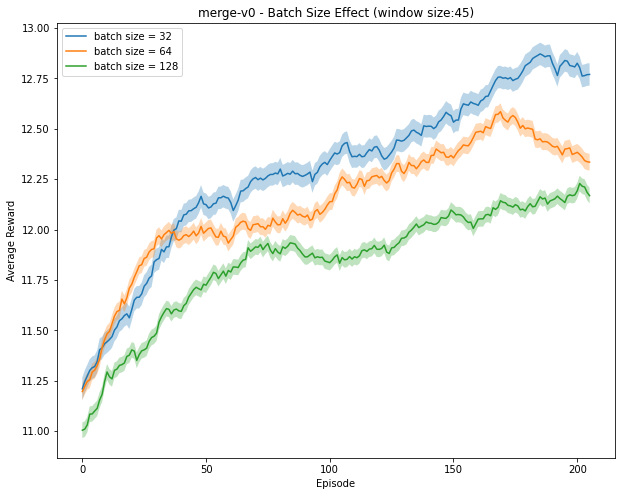

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

window_size = 45
cr1_ = np.convolve(np.mean(crs1, axis=0), np.ones(window_size)/window_size, mode='valid')
cr2_ = np.convolve(np.mean(crs2, axis=0), np.ones(window_size)/window_size, mode='valid')
cr3_ = np.convolve(np.mean(crs3, axis=0), np.ones(window_size)/window_size, mode='valid')
ci1 = 1.96 * np.std(cr1_)/np.sqrt(len(cr1_))
ci2 = 1.96 * np.std(cr2_)/np.sqrt(len(cr2_))
ci3 = 1.96 * np.std(cr3_)/np.sqrt(len(cr3_))

plt.figure(figsize=(10, 8))
plt.title("merge-v0 - Batch Size Effect (window size:"+str(window_size)+")")
plt.plot(cr1_, label='batch size = 32')
plt.plot(cr2_, label='batch size = 64')
plt.plot(cr3_, label='batch size = 128')
plt.fill_between(range(len(cr1_)), (cr1_-ci1), (cr1_+ci1), alpha=.3)
plt.fill_between(range(len(cr2_)), (cr2_-ci2), (cr2_+ci2), alpha=.3)
plt.fill_between(range(len(cr3_)), (cr3_-ci3), (cr3_+ci3), alpha=.3)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

<a name='2-3'></a>
## Render

In [ ]:
crs6, agent6, state_dict6, cpp6  = run_DeepQLearning_agent(_batch_size=32, reps=1)

Episode 25	Average Reward: 10.44	Epsilon: 0.47
Episode 50	Average Reward: 11.02	Epsilon: 0.22
Episode 75	Average Reward: 11.02	Epsilon: 0.10
Episode 100	Average Reward: 14.30	Epsilon: 0.05
Episode 125	Average Reward: 14.92	Epsilon: 0.02
Episode 150	Average Reward: 14.92	Epsilon: 0.01
Episode 175	Average Reward: 14.89	Epsilon: 0.01
Episode 200	Average Reward: 11.08	Epsilon: 0.01
Episode 225	Average Reward: 14.92	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01


In [ ]:
!pip install pygame 

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[(1024, 768)]

In [ ]:
# from gym.wrappers.monitoring import video_recorder
# vid = video_recorder.VideoRecorder(env,path="./recording/vid.mp4")
env = RecordVideo(env, video_folder="run",
              episode_trigger=lambda e: True)  # record all episodes

# Provide the video recorder to the wrapped environment
# so it can send it intermediate simulation frames.
env.unwrapped.set_record_video_wrapper(env)
done = truncated = False
S, info = env.reset()
while not (done or truncated):
  env.render()
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
env.close()



NameError: ignored

In [ ]:
%load_ext tensorboard
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git 2> /dev/null
sys.path.insert(0, '/content/highway-env/scripts/')
from utils import record_videos, show_videos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 9.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
done = truncated = False
S, info = env.reset()
env = record_videos(env)

while not (done or truncated):
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
  env.render(mode='rgb_array')

env.close()
show_videos()

/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <RecordVideo<OrderEnforcing<PassiveEnvChecker<MergeEnv<merge-v0>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from tqdm.notebook import trange

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    html = []
    for mp4 in Path("video").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
done = truncated = False
S, info = env.reset()
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)

while not (done or truncated):
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
  

env.close()
show_videos()



/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <RecordVideo<RecordVideo<RecordVideo<OrderEnforcing<PassiveEnvChecker<MergeEnv<merge-v0>>>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


In [ ]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

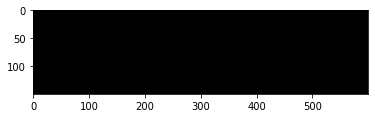

In [ ]:
done = truncated = False
S, info = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
while not (done or truncated):
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
ipythondisplay.clear_output(wait=True)
env.close()

<a name='2-4'></a>
## Hyperparameters

In [ ]:
import keras
from tensorflow.keras import *
from tensorflow.keras.utils import *
input = keras.layers.Input(shape=(5))
output = keras.layers.Flatten()(input)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dense(5, activation='relu')(output)
model = keras.models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 512)               3072      
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 530,949
Trainable params: 530,949
Non-trainab

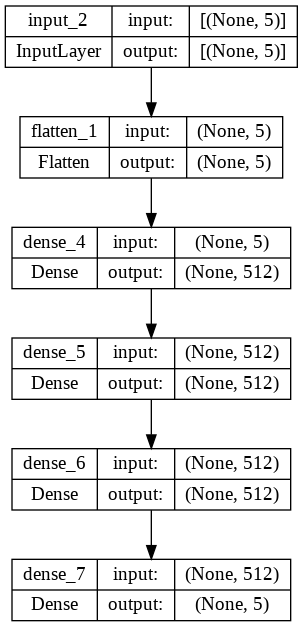

In [ ]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

<a name='3'></a>
# Part 3

In [ ]:
env = gym.make("highway-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_size, action_size 

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


(5, 5)

In [ ]:
start = time.time()
crs4, agent4 = run_DeepQLearning_agent(_batch_size=32, number_of_episodes=100, epsilon_decay_rate=0.95, reps=3)
end = time.time()

Episode 25	Average Reward: 28.07	Epsilon: 0.28
Episode 50	Average Reward: 29.36	Epsilon: 0.08
Episode 75	Average Reward: 27.98	Epsilon: 0.02
Episode 100	Average Reward: 28.46	Epsilon: 0.01
Episode 25	Average Reward: 5.85	Epsilon: 0.28
Episode 50	Average Reward: 28.21	Epsilon: 0.08
Episode 75	Average Reward: 28.47	Epsilon: 0.02
Episode 100	Average Reward: 29.05	Epsilon: 0.01
Episode 25	Average Reward: 1.07	Epsilon: 0.28
Episode 50	Average Reward: 9.07	Epsilon: 0.08
Episode 75	Average Reward: 27.23	Epsilon: 0.02
Episode 100	Average Reward: 9.04	Epsilon: 0.01


In [ ]:
print("highway-v0 with random weight learning time: ", (end - start))

highway-v0 with random weight learning time:  68.41666666666667


In [ ]:
start = time.time()
crs5, agent5 = run_DeepQLearning_agent(_batch_size=32, _agent=agent1, number_of_episodes=100, epsilon_decay_rate=0.95, reps=3)
end = time.time()

Episode 25	Average Reward: 27.74	Epsilon: 0.28
Episode 50	Average Reward: 8.25	Epsilon: 0.08
Episode 75	Average Reward: 31.96	Epsilon: 0.02
Episode 100	Average Reward: 10.41	Epsilon: 0.01
Episode 25	Average Reward: 29.20	Epsilon: 0.28
Episode 50	Average Reward: 28.58	Epsilon: 0.08
Episode 75	Average Reward: 24.05	Epsilon: 0.02
Episode 100	Average Reward: 28.47	Epsilon: 0.01
Episode 25	Average Reward: 23.33	Epsilon: 0.28
Episode 50	Average Reward: 30.03	Epsilon: 0.08
Episode 75	Average Reward: 17.44	Epsilon: 0.02
Episode 100	Average Reward: 22.11	Epsilon: 0.01


In [ ]:
print("highway-v0 with trained weight learning time: ", (end - start)/60)

highway-v0 with trained weight learning time:  66.73571458657582


<a name='3-1'></a>
## Result

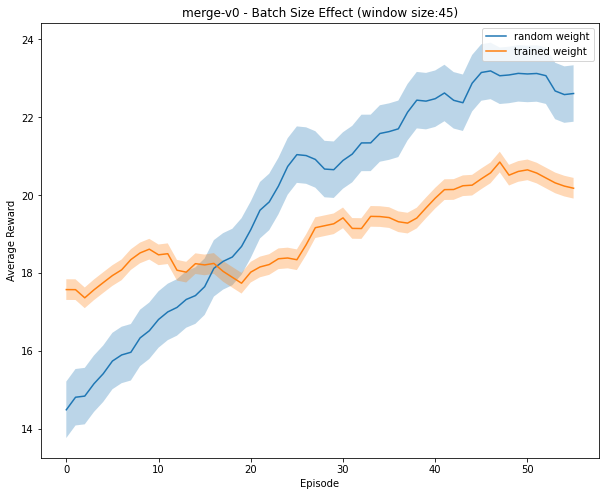

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

window_size = 45
cr4_ = np.convolve(np.mean(crs4, axis=0), np.ones(window_size)/window_size, mode='valid')
cr5_ = np.convolve(np.mean(crs5, axis=0), np.ones(window_size)/window_size, mode='valid')
ci4 = 1.96 * np.std(cr4_)/np.sqrt(len(cr4_))
ci5 = 1.96 * np.std(cr5_)/np.sqrt(len(cr5_))

plt.figure(figsize=(10, 8))
plt.title("merge-v0 - Batch Size Effect (window size:"+str(window_size)+")")
plt.plot(cr4_, label='random weight')
plt.plot(cr5_, label='trained weight')
plt.fill_between(range(len(cr4_)), (cr4_-ci4), (cr4_+ci4), alpha=.3)
plt.fill_between(range(len(cr5_)), (cr5_-ci5), (cr5_+ci5), alpha=.3)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

<a name='4'></a>
# Part 4

<a name='4-1'></a>
## Subsection 1

<a name='4-2'></a>
## Subsection 2